<a href="https://colab.research.google.com/github/jagrutimohanty/AlgoRepo/blob/master/CMPE_257_Assignment1_Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Name : Jagruti Mohanty sjsu email id= jagruti.mohanty@sjsu.edu
## CMPE-257 Assignment-1 Submission (Kemans Implementation)


### Project dataset - Project Idea is to classify if there was any intrusion/attack by analysing the web logs . The dataset is prelabelled and it is a multiclass classification with the attack types and whether there was no attack(normal)

### With KMeans clustering analysis as unsupervised learning approach used to identify similar type of attacks and group them based on the features. 

### In the log data there are 41 features and a predicted label column.
### For implementation purpose : 
####  Picked 100 records from the dataset 
####      Applied label encoding on none numerical features
####      Applied PCA to convert it into a two features set and 
####      converted it into dateframe with columns 
####      Passed it into the kmeans algorithm using tensor flow
####      Plotted the output in scatter plot 2d format
####      Defined the tensorflow model in a function
####      Called the function to trigger the tensorflow model 
####      The output was same as using the sklearn library 
####      Clustered using 6 groups 

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:


#Import modules
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:


#Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



In [ ]:
#Get the Shareable link
downloaded = drive.CreateFile({'id':"1-O-DGRQK9KmuXQPQZ7hURbQlXc5zG3kg"})   
downloaded.GetContentFile('intrusiondataset.csv')       



In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:

df_data = pd.read_csv("intrusiondataset.csv",nrows=100000,sep=',',engine='python')
#Read data
df_data = df_data.sample(100)
df_data.head()


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Prediction Label
26150,0,tcp,http,SF,225,751,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,5,0.00,0.0,0.00,0.0,1.0,0.0,0.4,84,255,1.0,0.0,0.01,0.05,0.00,0.0,0.00,0.00,normal.
91985,0,tcp,other,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,511,1,0.04,1.0,0.96,0.0,0.0,1.0,0.0,255,1,0.0,1.0,0.00,0.00,0.07,1.0,0.93,0.00,satan.
82012,0,tcp,http,SF,207,1425,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,10,10,0.00,0.0,0.00,0.0,1.0,0.0,0.0,185,185,1.0,0.0,0.01,0.00,0.00,0.0,0.01,0.01,normal.
78576,0,icmp,eco_i,SF,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.00,0.0,0.00,0.0,1.0,0.0,0.0,100,100,1.0,0.0,1.00,0.00,0.00,0.0,0.00,0.00,normal.
96867,0,icmp,ecr_i,SF,1032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,511,511,0.00,0.0,0.00,0.0,1.0,0.0,0.0,255,255,1.0,0.0,1.00,0.00,0.00,0.0,0.00,0.00,smurf.


#### This is to drop the known label also as shown the that the labels are normal , neptune , smurf , satan , ipsweep , back etc 

In [ ]:
df_without_lb = df_data.drop(['Prediction Label'], axis=1)

In [ ]:
df_data['Prediction Label'].unique()

array(['portsweep.', 'normal.', 'neptune.', 'back.', 'smurf.'],
      dtype=object)

#### This is to convert the labels

In [ ]:
df_without_lb.loc[:,'protocol_type'] = LabelEncoder().fit_transform(df_data.loc[:,'protocol_type'].copy())
df_without_lb.loc[:,'service'] = LabelEncoder().fit_transform(df_data.loc[:,'service'].copy())
df_without_lb.loc[:,'flag'] = LabelEncoder().fit_transform(df_data.loc[:,'flag'].copy())

In [ ]:
df_without_lb

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
86256,0,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,1.0,1.0,1.00,0.00,0.00,255,1,0.00,1.00,1.00,0.00,0.0,0.0,1.0,1.0
17009,0,1,3,2,222,6618,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,11,11,0.0,0.0,0.0,0.0,1.00,0.00,0.00,11,255,1.00,0.00,0.09,0.04,0.0,0.0,0.0,0.0
22473,0,1,3,2,233,5069,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,4,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,255,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
38066,0,1,3,2,287,2168,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,11,11,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,255,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
60262,0,1,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,107,10,1.0,1.0,0.0,0.0,0.09,0.06,0.00,255,10,0.04,0.07,0.00,0.00,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65325,0,1,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,95,1,1.0,1.0,0.0,0.0,0.01,0.08,0.00,255,1,0.00,0.07,0.00,0.00,1.0,1.0,0.0,0.0
58845,0,1,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,278,6,1.0,1.0,0.0,0.0,0.02,0.06,0.00,255,6,0.02,0.07,0.00,0.00,1.0,1.0,0.0,0.0
15590,0,1,3,2,212,984,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,26,26,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,255,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
38620,0,1,3,2,288,2055,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,9,0.0,0.0,0.0,0.0,1.00,0.00,0.22,250,255,1.00,0.00,0.00,0.02,0.0,0.0,0.0,0.0


#### Converted the dataframe into an numpyobject

In [ ]:
df_without_lb_np  = df_without_lb.to_numpy()
df_without_lb_np.shape

(100, 41)

#### PCA applied to the data

In [ ]:
#Transform the data
pca = PCA(2)
df_pca = pca.fit_transform(df_without_lb_np)

In [ ]:
df_pca.shape

(100, 2)

### Prediction using tensoflow Kmeans

In [ ]:
tf.compat.v1.disable_eager_execution()

def k_means_clustering(feature1, feature2, clusters, steps=100):
    '''
    Takes in two dataframe columns and outputs plot of clusters.
    '''
    vec_vals = []
    for i in range(len(feature1)):
        a = feature1[i]
        b = feature2[i]
        vec_vals.append([a, b])
    v_vals = np.array(vec_vals)
    np.random.shuffle(v_vals)    
    
    sess = tf.compat.v1.Session()
    k = clusters
    points = v_vals
    data = tf.constant(points)
    
   
    # taking initial centroids 
    centroids = tf.Variable(data[:k, :])

   
    # for array operations instead of loops
    #used the expand dimension to make it compatible   
    data_expanded = tf.expand_dims(data, 0)
    centroids_expanded = tf.expand_dims(centroids, 1)

   
    # Calculating the distance matrix and finding the closed centroid points
    allocations = tf.argmin(tf.reduce_sum(tf.square(data_expanded - centroids_expanded), 2), 0)

    sess.run(tf.compat.v1.global_variables_initializer())
    c = 0 # index of centroid
    tf.equal(allocations, c)
    tf.gather(data, tf.where(tf.equal(allocations, c)))

    means = tf.concat(
        [tf.reduce_mean(
            tf.gather(data,
                      tf.where(tf.equal(allocations, c))), 0) for c in range(k)], 0)

    update_centroids = tf.compat.v1.assign(centroids, means)

    for step in range(steps):
        _, centroid_values, allocation_values = sess.run([update_centroids, centroids, allocations])
        
    clus = pd.DataFrame({feature1.name: points[:,0], feature2.name: points[:,1], "cluster": allocation_values})
    sns.lmplot(feature1.name, feature2.name, data=clus, fit_reg=False, size=6, hue="cluster")
    plt.show()

In [ ]:
pca_cols_df = pd.DataFrame(data = df_pca
             , columns = ['principal component 1', 'principal component 2'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


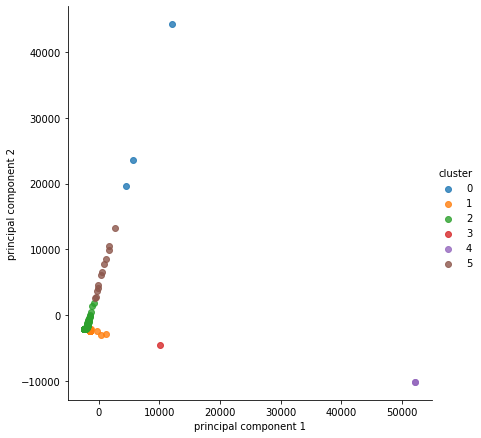

In [ ]:
k_means_clustering(pca_cols_df['principal component 1'], pca_cols_df['principal component 2'], 6)

In [ ]:
#Initialize the class object
kmeans = KMeans(n_clusters= 6)

### Prediction using Sklearn Kmeans

In [ ]:
#predict using labels
lbl = kmeans.fit_predict(df_pca)

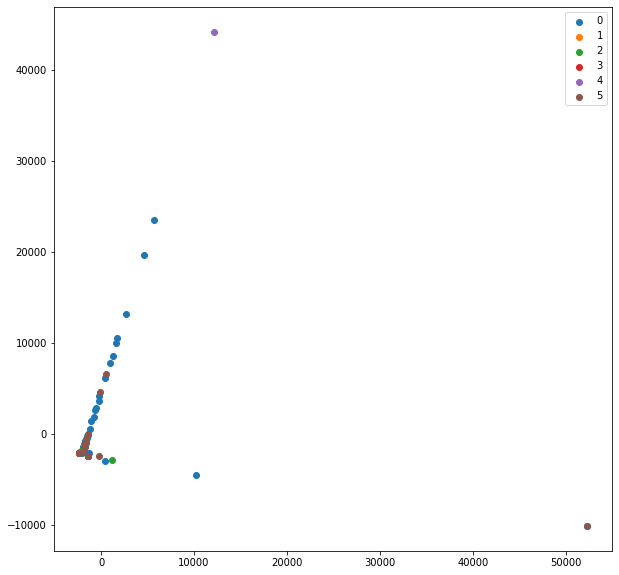

In [ ]:
#Getting labels from the previous step
lbl_unique = np.unique(lbl)
 
#plotting the output in 2 d scatter plot
plt.figure(figsize=(10,10))

for i in lbl_unique:
    plt.scatter(df_pca[label == i , 0] , df_pca[label == i , 1] , label = i)
plt.legend()
plt.show()

### The interpretation is finding similar kind of web activites and this helps businesses to use the power of Machine Learning in securing there websites, data from various attacks